<a href="https://colab.research.google.com/github/priscillaoclark/15.773-hands-on-deep-learning/blob/main/HODL_SP25_Lec_03_Sec_A_Tabular_Data_Prediction_Hyperparam_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification on Tabular Data - Predicting Heart Disease





## Introduction

This colab shows how to set up and train a Neural Network model for *binary classification*, when the dataset is *tabular* (rather than unstructured data like images or text) and has a mix of numeric and categorical features. Since tabular datasets are often made available in CSV files, the colab demonstrates the full CSV-to-trained-model workflow.




### The dataset

The dataset ([more background on the data](https://archive.ics.uci.edu/ml/datasets/heart+Disease)) has information on 303 patients, one in each row. Each column (i.e., feature) contains information on a particular attribute of the patient. The column named "Target" indicates if the patient has been diagnosed with heart disease or not and is the label (i.e., the dependent variable) that we want to predict using the other columns.

Feature description (copied from [here](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)):

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Technical preliminaries

Throughout the course, we will load the following packages as the first step.

In [ ]:
# For this colab, we will use 'tensorflow' as the backend library
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

When we train Deep Learning models, randomness enters the process in a few different places.
*   Starting values for the weights (the optimizer will try to improve these weights)
*   The order in which we process the minibatches when we do SGD
*   When we split the data into Train, Validation, Test etc
*   Dropout (if we use regularization)

We next set the seed for the different random number generators so that the
results will be the same every time the notebook is run. 🤞



In [ ]:
keras.utils.set_random_seed(42)

## Read in the data

Conveniently, the dataset in CSV form has been made available online (by [Francois Chollet](https://twitter.com/fchollet)) and we can load it into a Pandas dataframe with the very useful `pd.read_csv` command.

In [ ]:
df = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")

In [ ]:
df.shape

(303, 14)

The dataset has 303 rows and 14 columns (13 independent variables + 1 dependent variable):

Let's take a look at the first few rows:

In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


Let's take a quick look to see if the 1s and 0s are balanced.

In [ ]:
df.target.value_counts(normalize=True, dropna=False)

,proportion
target,
0,0.726073
1,0.273927


It is a bit imbalanced.

What's a 'naive' **baseline model** for this problem?

<br> <br> <br> <br>

A baseline model would be to just predict a probability of 0.0 for every patient. That will result in 72.6% accuracy.

Any fancy model we build needs to do better than this.

We will come back to this later.

## Preprocessing

This dataset has both categorical variables and numeric variables.

It will be convenient (for later processing) to collect these groups of variables into two lists.

In [ ]:
categorical_variables = ['sex', 'cp', 'fbs', 'restecg','exang', 'ca', 'thal']
numerics = ['age', 'trestbps','chol', 'thalach', 'oldpeak', 'slope']

NNs require all their inputs to be numeric so we will first preprocess this raw data as follows:
- *one-hot encode* the categorical variables
- *normalize* the numeric variables


With the pandas `get_dummies` function, you can one-hot-encode in one line.


In [ ]:
df = pd.get_dummies(df, columns = categorical_variables, dtype=float)

In [ ]:
df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,63,145,233,150,2.3,3,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,67,160,286,108,1.5,2,1,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,67,120,229,129,2.6,2,0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,37,130,250,187,3.5,3,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,41,130,204,172,1.4,1,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0



NNs work best when the inputs are all roughly in the same range. So standard practice is to **standardize** the numeric variables.

Before we do so, let's split the data into an 80% training set and a 20% validation set (*why should we split **before** normalization?*).


In [ ]:
val_df = df.sample(frac=0.2, random_state=42)
train_df = df.drop(val_df.index)

In [ ]:
train_df.shape

(242, 30)

In [ ]:
val_df.shape

(61, 30)

OK, let's calculate the mean and standard deviation of every numeric variable in the training set.

In [ ]:
means = train_df[numerics].mean()
sd = train_df[numerics].std()

In [ ]:
means

,0
age,54.268595
trestbps,131.995868
chol,246.512397
thalach,149.805785
oldpeak,1.032645
slope,1.590909


Let's standardize the train and validation dataframes with these means and standard deviations.

In [ ]:
train_df[numerics]= (train_df[numerics] - means)/sd

In [ ]:
val_df[numerics]= (val_df[numerics] - means)/sd

In [ ]:
train_df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,0.963746,0.721939,-0.278690,0.008396,1.083461,2.226814,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.405254,1.554681,0.814423,-1.807247,0.399542,0.646494,1,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.405254,-0.665964,-0.361189,-0.899426,1.339930,0.646494,0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.906055,-0.110803,0.071931,1.607891,2.109339,2.226814,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.464547,-0.110803,-0.876809,0.959447,0.314052,-0.933825,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


At this point, the data is entirely numeric.

The easiest way to feed data to Keras is as Numpy arrays so we convert our two dataframes to Numpy arrays.

In [ ]:
train = train_df.to_numpy()
val = val_df.to_numpy()

Final step: Our features $X$ and dependent variable $y$ are both inside the `train` and `test` arrays so let's separate them out.

Note that the `target` column is our $y$ variable and it is column #6 from the left (counting from 0).

The `np.delete` function is perfect for selecting all columns except one.

In [ ]:
train_X = np.delete(train, 6, axis=1)
val_X = np.delete(val, 6, axis=1)

Check that it worked.

In [ ]:
train_X.shape, val_X.shape

((242, 29), (61, 29))

Next, select just the 6th column and define the train and test $y$ variables.

In [ ]:
train_y = train[:, 6]
val_y = val[:, 6]

In [ ]:
train_y.shape, val_y.shape


((242,), (61,))

## Build a model


Creating an NN  is usually just a few lines of Keras code as we saw in class.

* We will start with a single hidden layer.
* Since this is a *binary classification problem*, we will use a sigmoid activation in the output layer.

The following model is what we created in class.

In [ ]:
# define the input layer
input = keras.layers.Input(shape=train_X.shape[1:])

# feed the input vector to the hidden layer
# optional: you can give names to each layer to help
# keep track. This doesn't affect the training etc.

h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# feed the output of the hidden layer to the output layer
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

The `model.summary()` command is a good way to get a quick overview of what you have defined.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden (Dense)                       │ (None, 16)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

Let's hand-calculate the number of parameters to verify.

In [ ]:
(29 + 1)* 16 + (16 + 1) * 1

497

We can "visualize" the network graphically as well using Keras' `plot_model` function.

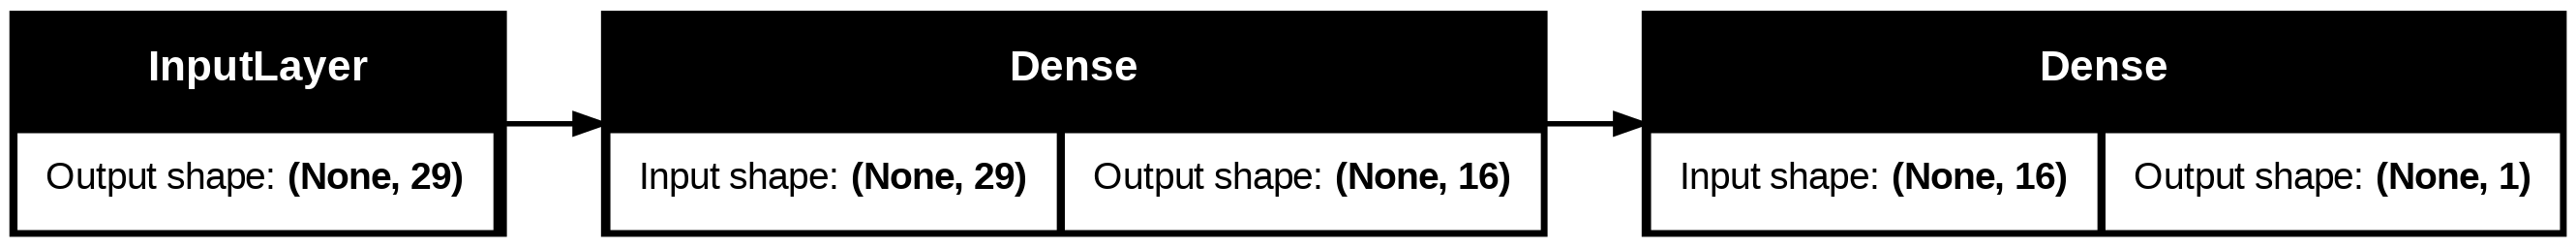

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Set optimization parameters

Now that the model is defined, we need to tell Keras three things:

*   What **loss function** to use - Since our output variable is binary, we will select the `binary_crossentropy` loss function.
*   Which **optimizer** to use - we will use a sibling of SGD called **Adam** which is an excellent default choice
*   What **metrics** you want Keras to report out - in classification problems like this one, Accuracy is usually the metric you want to see.

These three choices can be made using the `model.fit` function.

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## Train the model

To kickoff training, we need to do three things:
* Set the *batch size*. We referred to this as a *minibatch* in lecture but in keeping with convention, we will simply refer to it as *batch* from this point on. 32 is a good default for the batch size.
* Set the number of *epochs* i.e., how many passes through the training data. Usually 20-30 epochs is a good starting point but since this dataset is very small, each epoch will be very quick so let's run it for 100 epochs. It will allow us to see if any overfitting happens
* Pass in the training and validation datasets we created earlier.

OK, let's train the model using the `model.fit` function!

We will store the output of the training process in `history`. It will make it easy later to investigate what happened during training.

In [ ]:
history = model.fit(train_X,              # the array with the input X columns
                    train_y,              # the array with the output y column
                    epochs=100,           # number of epochs to run
                    batch_size=32,        # number of samples (ie data points) per batch
                    verbose=1,            # verbosity during training
                    validation_data=(val_X, val_y)) # validation data

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5743 - loss: 0.7004 - val_accuracy: 0.6557 - val_loss: 0.6515
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6137 - loss: 0.6596 - val_accuracy: 0.7049 - val_loss: 0.6183
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6580 - loss: 0.6253 - val_accuracy: 0.7213 - val_loss: 0.5876
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6999 - loss: 0.5946 - val_accuracy: 0.7377 - val_loss: 0.5598
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7039 - loss: 0.5667 - val_accuracy: 0.7541 - val_loss: 0.5351
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7235 - loss: 0.5410 - val_accuracy: 0.7869 - val_loss: 0.5125
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7565 - loss: 0.5175 - val_accuracy: 0.8197 - val_loss: 0.4915
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7686 - loss: 0.4957 - val_accuracy: 0.8197 - val_loss

Let's take a moment to understand the numbers being reported.


---



Plotting metrics like loss and accuracy as a function of the # of epochs is a good way to understand how training has progressed.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

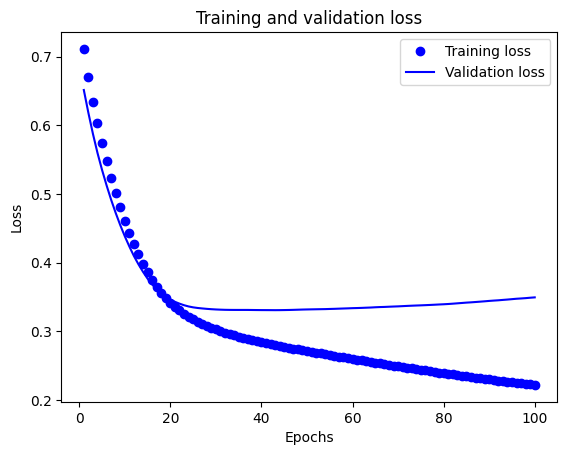

In [ ]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/

loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

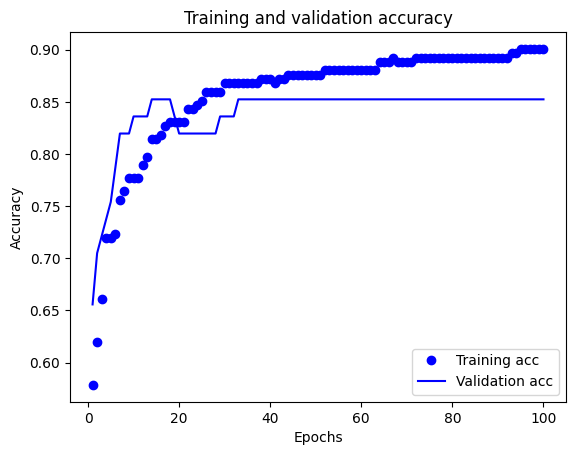

In [ ]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Do you think there's overfitting?


## Evaluate the model

`model.evaluate` is a very handy function to calculate the performance of your model on *any* dataset.

Let's try it on the validation dataset and see if the numbers match the Keras output from above.

In [ ]:
model.evaluate(val_X, val_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8496 - loss: 0.3564


[0.3492735028266907, 0.8524590134620667]

It does.

How does the accuracy of this "neural model" 😀 compare to the accuracy of our baseline model?

The baseline model had an accuracy of 72.6% so our first NN model is certainly beating that by a healthy margin!


## Predict using the model

Making predictions with a Keras model is easy with the `model.predict` function.

Let's predict the cardiac risk for the first 10 patients in the validation set.

In [ ]:
print(model.predict(val_X[:10]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
[[0.1794373 ]
 [0.62371427]
 [0.00239498]
 [0.01407938]
 [0.05319878]
 [0.9179082 ]
 [0.35208434]
 [0.00139544]
 [0.21029271]
 [0.09280711]]


## Hyperparameter Optimization


We will use a Python package called **[Keras Tuner](https://keras.io/keras_tuner/)** to do hyperparameter optimization.

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

### Optimizing a **single** hyperparameter

The NN we set up and trained earlier had a single hidden layer NN with 16 neurons. We will now see how to optimize the number of neurons in that hidden layer.


We will first define a function that creates a Keras model. Keras Tuner will use this function repeatedly to create different models, train them, and will report back the results to us.

In [ ]:
def build_model(hp):
    input = keras.layers.Input(shape=train_X.shape[1:])

    x = keras.layers.Dense(
        # The next line is the important line.
        # Instead of specifying a particular number
        # for 'units', we set it equal to a special hyperparameter
        # variable called hp.Choice where we list the values
        # that we want Keras Tuner to search over
        units=hp.Choice(f"units", [4, 8, 12, 16, 32, 64]),
        activation="relu")(input)

    output = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(input,output)

    model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

    return model

Next, we set up a "tuner" that will search for the best hyperparameter value.

We will use [`GridSearch`](https://keras.io/keras_tuner/api/tuners/grid/) which will try **every** choice of 'units' that we listed in `hp.Choice` above. BTW, KerasTuner offers many [alternatives](https://keras.io/keras_tuner/api/tuners/) to `GridSearch` that you can explore if you are interested.


In [ ]:
tuner = kt.GridSearch(
    build_model,               # we pass in the model-building function we created
    objective="val_accuracy",  # we tell the optimizer to find the hyperparameter with the max validation accuracy
    overwrite=True             # an annoying little technical detail - don't worry about it
)

After we set up the tuner, we can see its search space.

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
units (Choice)
{'default': 4, 'conditions': [], 'values': [4, 8, 12, 16, 32, 64], 'ordered': True}


When we run the command below, for every value in [4, 8, 12, 16, 32, 64], the tuner will create a Keras model with that many hidden units, train it for 100 epochs and a batch size of 32, calculate accuracy on the validation set, and report back the results.

In [ ]:
# Conveniently, the arguments to tuner.search are exactly the same as model.fit

tuner.search(train_X,
             train_y,
             epochs=100,
             batch_size=32,
             verbose=1,
             validation_data=(val_X, val_y))

Trial 6 Complete [00h 00m 13s]
val_accuracy: 0.8524590134620667

Best val_accuracy So Far: 0.868852436542511
Total elapsed time: 00h 01m 22s


The optimizer is done. Let's see what it found.

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0004 summary
Hyperparameters:
units: 32
Score: 0.868852436542511

Trial 0000 summary
Hyperparameters:
units: 4
Score: 0.8524590134620667

Trial 0001 summary
Hyperparameters:
units: 8
Score: 0.8524590134620667

Trial 0002 summary
Hyperparameters:
units: 12
Score: 0.8524590134620667

Trial 0005 summary
Hyperparameters:
units: 64
Score: 0.8524590134620667

Trial 0003 summary
Hyperparameters:
units: 16
Score: 0.8360655903816223


**Results**

The best model has an accuracy of **86.88%** and uses 32 units in the hidden layer.

We can use the `tuner.get_best_models()` function to get this model.


In [ ]:
# tuner.get_best_models(1) returns a list with one element
# so we need to do tuner.get_best_models(1)[0] to get the model

best_model = tuner.get_best_models(1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Since this is a regular Keras model, all model related methods are available.

In [ ]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Notice that the hidden layer has 32 units, like we would expect.

We can evaluate this model on the validation dataset to see if the accuracy numbers match what we saw earlier.

In [ ]:
best_model.evaluate(val_X, val_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.8813 - loss: 0.3599


[0.3727113902568817, 0.868852436542511]

Good. They match.

This model can be directly used for prediction using `best_model.predict()`.

### Optimizing **multiple** hyperparameters

In the example above, we searched for the best value for one hyperparameter: the number of units in the single hidden layer.

What if we want to optimize across multiple hyperparameters?
- the number of layers
- the number of units in each layer
- the learning rate used by Adam
- the activation function

No problem. This is all easily doable using Keras Tuner.

I have provided a new `build_model` function below that varies all of these things. Read through it carefully. I have only used `hp.Choice` and `hp.Int` below but there are  [many others](https://keras.io/keras_tuner/api/hyperparameters/) we can use.



In [ ]:
def build_model(hp):

  input = keras.layers.Input(shape=train_X.shape[1:])

  x = input

  # Vary the number of layers
  for i in range(hp.Int("num_layers", 1, 3)):
      x = keras.layers.Dense(
          # Vary the number of units
          units=hp.Choice(f"units", [4, 8, 12, 16, 32, 64]),
          # Vary the activation function
          activation=hp.Choice("activation", ["relu", "sigmoid"]),
      )(x)

  output = keras.layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(input,output)

  # Vary the learning rate
  learning_rate = hp.Choice("lr", [1e-4, 1e-3, 1e-2])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )

  return model

Below, I just repeat the steps we did for the single-hyperparameter case.

In [ ]:
tuner = kt.GridSearch(
    build_model,
    objective="val_accuracy",
    overwrite=True
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units (Choice)
{'default': 4, 'conditions': [], 'values': [4, 8, 12, 16, 32, 64], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
lr (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [ ]:
tuner.search(train_X,
             train_y,
             epochs=100,
             batch_size=32,
             verbose=1,
             validation_data=(val_X, val_y))

Trial 108 Complete [00h 00m 15s]
val_accuracy: 0.868852436542511

Best val_accuracy So Far: 0.9180327653884888
Total elapsed time: 00h 26m 24s


That took 26 minutes to run!!

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0074 summary
Hyperparameters:
num_layers: 3
units: 4
activation: relu
lr: 0.01
Score: 0.9180327653884888

Trial 0041 summary
Hyperparameters:
num_layers: 2
units: 4
activation: sigmoid
lr: 0.01
Score: 0.8852459192276001

Trial 0077 summary
Hyperparameters:
num_layers: 3
units: 4
activation: sigmoid
lr: 0.01
Score: 0.8852459192276001

Trial 0092 summary
Hyperparameters:
num_layers: 3
units: 16
activation: relu
lr: 0.01
Score: 0.8852459192276001

Trial 0095 summary
Hyperparameters:
num_layers: 3
units: 16
activation: sigmoid
lr: 0.01
Score: 0.8852459192276001

Trial 0096 summary
Hyperparameters:
num_layers: 3
units: 32
activation: relu
lr: 0.0001
Score: 0.8852459192276001

Trial 0005 summary
Hyperparameters:
num_layers: 1
units: 4
activation: sigmoid
lr: 0.01
Score: 0.868852436542511

Trial 0011 summary
Hyperparameters:
num_layers: 1
units: 8
activation: sigmoid
lr:

Wow, the best model has has a validation accuracy of **91.8%**, achieved with these hyperparameters:
* num_layers: 3
* units: 4
* activation: relu
* learning rate: 0.01

**Summary**:
* our first model (before using Keras Tuner) had a validation accuracy of **85.25%**.
* our second model that used Tuner to search across the number of hidden units had a validation accuracy of **86.88%**.
* our third model that used Keras Tuner to search across lots of variations came in at **91.8%**!

Nice improvement! 🚀🚀🚀!!

In [ ]:
best_model = tuner.get_best_models(1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165 (660.00 B)

 Trainable params: 165 (660.00 B)

 Non-trainable params: 0 (0.00 B)

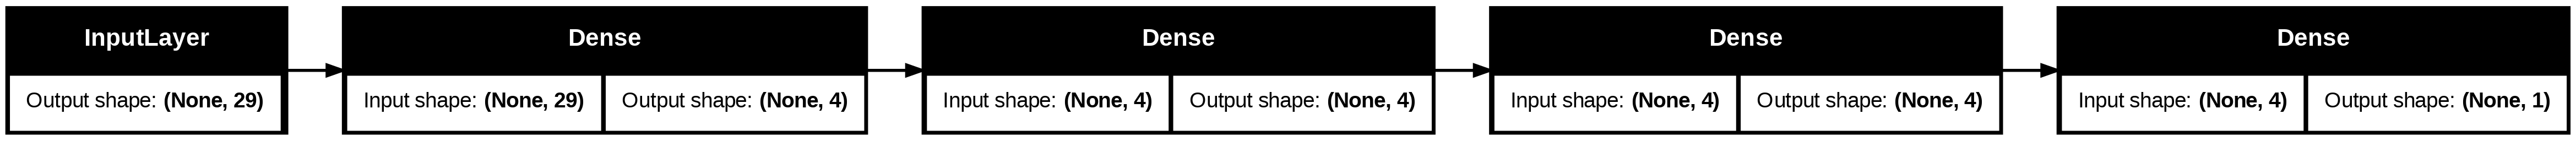

In [ ]:
keras.utils.plot_model(best_model, show_shapes=True, rankdir="LR")

In [ ]:
best_model.evaluate(val_X, val_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.9141 - loss: 0.4419


[0.38386252522468567, 0.9180327653884888]

Let's make predictions with this model for the first 10 patients in the validation set.

In [ ]:
print(best_model.predict(val_X[:10]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
[[4.5524184e-09]
 [9.3857312e-01]
 [3.3418505e-21]
 [5.1017324e-10]
 [4.0640481e-07]
 [7.5125390e-01]
 [4.5527600e-02]
 [1.5147639e-24]
 [6.7663314e-05]
 [2.1245095e-04]]


**THE END**

## [OPTIONAL] Preprocessing INSIDE the model

In this notebook, we did all the pre-processing - the one-hot encoding and normalization - *outside* the model. This means that we have to remember what pre-processing we did and carry that information (e.g., the mean and variance of each variable) along with the model to correctly use the model to make predictions in the future.

A very elegant way to avoid this issue is to use the Keras *FeatureSpace* utility. In the interest of time, we aren't covering it in this colab but we encourage you to check out this [colab](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/structured_data/ipynb/structured_data_classification_with_feature_space.ipynb) which shows how to solve our exact heart-disease prediction problem above using preprocessing layers.
